<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Thanks for taking the time to improve the project! It is accepted now. Keep up the good work on the next sprint! :)

</div>

**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a pretty good job overall, but there are a couple of problems that need to be fixed before the project is accepted. Let me know if you have any questions!

# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
pip install scikit-learn --upgrade

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (1.0.2)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import math
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle
from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4129,1,19.0,35600.0,2,0
269,1,34.0,24400.0,1,0
4517,0,21.0,48600.0,0,0
4553,1,25.0,39700.0,2,0
3666,0,31.0,49900.0,1,0
4642,0,27.0,43900.0,0,0
4538,1,23.0,39500.0,0,0
2217,1,32.0,40000.0,1,0
1861,1,37.0,52400.0,0,0
2539,0,29.0,42800.0,3,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null float64
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype(int)

In [8]:
# check to see that the conversion was successful
df.info()
#age was converted to int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null int64
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [9]:
df = df.drop_duplicates().reset_index()

In [10]:
df['income'] = df['income'].astype('int64')

In [11]:
#Check for null values
df.isnull().sum()

index                 0
gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

In [12]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

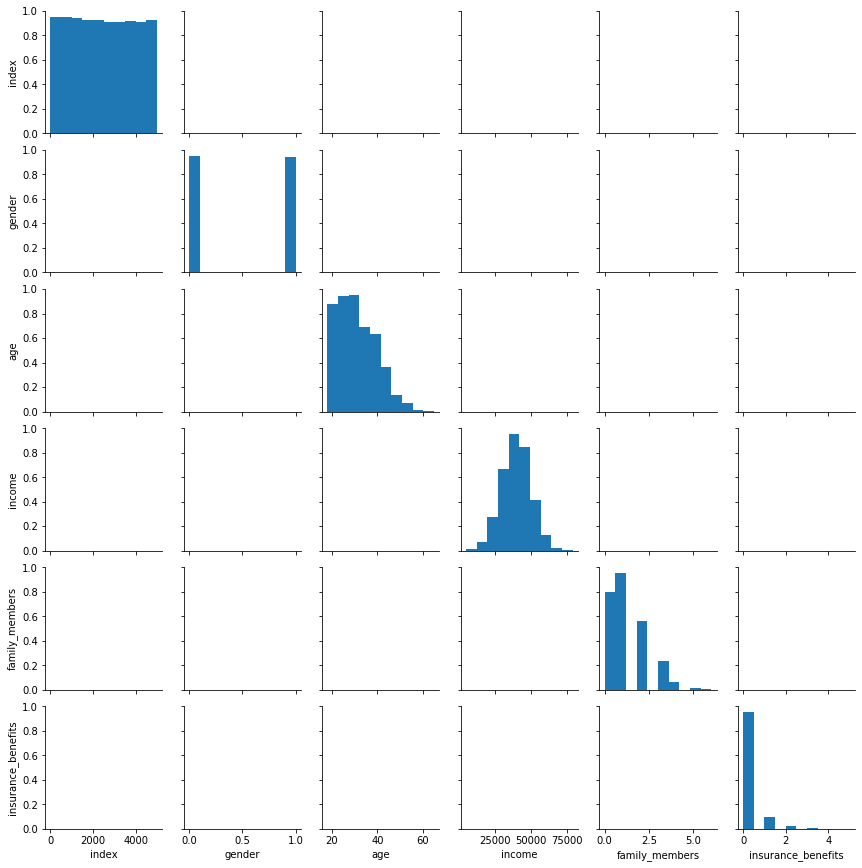

In [13]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']
target = df.drop(columns = ['insurance_benefits'], axis=1)

In [15]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric) # <write code here>
    nbrs.fit(df[feature_names], target)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    #kneighbors methods: finds the k neighbors of a point
    
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

<div class="alert alert-success">
<b>Reviewer's comment</b>

The function for getting k nearest neighbors is correct

</div>

1) .kneighbors method: finds the k neighbors of a point.
    a. Ex: df.kneighbors([X, n_neighbors,return_distance[)

Unscaled data

In [16]:
df.sample(5)

,index,gender,age,income,family_members,insurance_benefits
898,905,1,44,32100,1,1
1120,1130,1,38,50200,2,0
1029,1037,1,52,31400,1,2
4801,4953,0,42,61400,3,0
371,372,0,37,33700,1,0


Scaling the data.

In [17]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [18]:
df_scaled.sample(5)

,index,gender,age,income,family_members,insurance_benefits
231,231,0.0,0.538462,0.522785,0.333333,0
731,735,0.0,0.276923,0.693671,0.166667,0
3233,3319,1.0,0.323077,0.494937,0.500000,0
4623,4770,0.0,0.584615,0.630380,0.000000,0
1466,1481,0.0,0.507692,0.688608,0.166667,0


Now, let's get similar records for a given one for every combination: 1) unscaled, euclidean, 2) scaled, euclidean 3) unscaled, manhattan 4) scaled, manhattan

In [19]:
# case 1: unscaled, euclidean
get_knn(df, 10, 5, 'euclidean')

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


,index,gender,age,income,family_members,insurance_benefits,distance
10,10,1,25,36600,1,0,0.000000
3924,4039,1,25,36600,2,0,1.000000
2007,2037,1,26,36600,0,0,1.414214
3169,3247,1,26,36600,2,0,1.414214
1492,1508,0,26,36600,0,0,1.732051


In [20]:
#case 2: scaled, euclidean
get_knn(df_scaled, 10, 5, 'euclidean')

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


,index,gender,age,income,family_members,insurance_benefits,distance
10,10,1.0,0.384615,0.463291,0.166667,0,0.000000
4243,4377,1.0,0.384615,0.473418,0.166667,0,0.010127
1374,1389,1.0,0.369231,0.464557,0.166667,0,0.015437
756,760,1.0,0.369231,0.462025,0.166667,0,0.015437
2219,2254,1.0,0.400000,0.455696,0.166667,0,0.017157


In [21]:
#case 3: unscaled, manhattan
get_knn(df, 10, 5, 'manhattan')

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


,index,gender,age,income,family_members,insurance_benefits,distance
10,10,1,25,36600,1,0,0.0
3924,4039,1,25,36600,2,0,1.0
2007,2037,1,26,36600,0,0,2.0
3169,3247,1,26,36600,2,0,2.0
1492,1508,0,26,36600,0,0,3.0


In [22]:
#case 4: scaled, manhattan
get_knn(df_scaled, 10, 5, 'manhattan')

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


,index,gender,age,income,family_members,insurance_benefits,distance
10,10,1.0,0.384615,0.463291,0.166667,0,0.000000
4243,4377,1.0,0.384615,0.473418,0.166667,0,0.010127
1374,1389,1.0,0.369231,0.464557,0.166667,0,0.016650
756,760,1.0,0.369231,0.462025,0.166667,0,0.016650
2219,2254,1.0,0.400000,0.455696,0.166667,0,0.022980


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

<span style='color:blue'> The kNN algorithm is affected because the indexes chosen are different when the data is scaled vs. unscaled for both manhattan and euclidean metrics. </span>

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

<span style='color:blue'> The results were identical regardless of scaling, which is indicated by again comparing the indexes that were chosen. </span>

<div class="alert alert-warning">
<b>Reviewer's comment</b>

One important way in which the results on scaled vs unscaled data are different is that for unscaled data if one variable has a much bigger magnitude than others (like income), it dominates the distance metric, and the other features are treated as less important

</div>

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for **both the original data and the scaled one.** That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$


1) Create the df['insurance_benefits_received'] feature for **both** scaled and unscaled:

df['insurance_benefits_received'] = number of clients received any insurance benefit

In [23]:
#Unscaled insurance_benefits_received
conditions_us = [(df['insurance_benefits'] == 0),
             df['insurance_benefits'] != 0]

values = [0, 1] #1 meaning the client has received any number of insurance benefits

df['insurance_benefits_received'] = np.select(conditions_us, values)
df['insurance_benefits_received'].value_counts()

0    4284
1     563
Name: insurance_benefits_received, dtype: int64

In [24]:
#Scaled insurance_benefits_received
conditions_s = [(df_scaled['insurance_benefits'] == 0),
               df_scaled['insurance_benefits'] != 0]

values = [0,1]

df_scaled['insurance_benefits_received'] = np.select(conditions_s, values)
df_scaled['insurance_benefits_received'].value_counts()

0    4284
1     563
Name: insurance_benefits_received, dtype: int64

<div class="alert alert-success">
<b>Reviewer's comment</b>

Target variable is correct

</div>

Split the whole data in the 70:30 proportion for the training/testing parts.

In [25]:
#Splitting the data into 70:30 for training/testing

features_us = df.drop(['index', 'insurance_benefits', 'insurance_benefits_received'], axis=1)
target_us = df['insurance_benefits_received']
features_s = df_scaled.drop(['index', 'insurance_benefits', 'insurance_benefits_received'], axis=1)
target_s = df_scaled['insurance_benefits_received']

features_train_us, features_test_us, target_train_us, target_test_us = train_test_split(features_us, target_us, 
                                                                          train_size=0.70, random_state=12345)

features_train_s, features_test_s, target_train_s, target_test_s = train_test_split(features_s, target_s, 
                                                                          train_size=0.70, random_state=12345)

display(features_train_us.shape, target_train_us.shape, 
       features_test_us.shape, target_test_us.shape,
       features_train_s.shape, target_train_s.shape,
       features_test_s.shape, target_test_s.shape)

(3392, 4)

(3392,)

(1455, 4)

(1455,)

(3392, 4)

(3392,)

(1455, 4)

(1455,)

In [26]:
display(features_s, features_us)

,gender,age,income,family_members
0,1.0,0.630769,0.627848,0.166667
1,0.0,0.707692,0.481013,0.166667
2,0.0,0.446154,0.265823,0.000000
3,0.0,0.323077,0.527848,0.333333
4,1.0,0.430769,0.330380,0.000000
...,...,...,...,...
4842,0.0,0.430769,0.451899,0.333333
4843,0.0,0.523077,0.663291,0.166667
4844,0.0,0.307692,0.429114,0.333333
4845,1.0,0.338462,0.413924,0.500000


,gender,age,income,family_members
0,1,41,49600,1
1,0,46,38000,1
2,0,29,21000,0
3,0,21,41700,2
4,1,28,26100,0
...,...,...,...,...
4842,0,28,35700,2
4843,0,34,52400,1
4844,0,20,33900,2
4845,1,22,32700,3


Check for the class imbalance with value_counts()

In [27]:
#<your code here>
display(target_train_us.value_counts())

0    2997
1     395
Name: insurance_benefits_received, dtype: int64

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Upsampling is not a good idea for kNN. Remember how the algorithm works: for each new example which we want to make prediction for, we're looking at k nearest neighbors and assigning the most common target between them. If you upsample the training data, you're just adding duplicate rows, and so it's probable that all of the k nearest neighbors will be the same, so we're essnetially looking at 1 nearest neighbor regardless of the value of k.
    
So, please remove upsampling and check the results again

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Fixed!

</div>

In [28]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [29]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42): 
    #seed allows for reproducable results, commonly valued as 42
    #size is manually entered (size of df)
    #P is probabilities which will be entered in the form of a loop in the next cell

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

**Dummy model evaluation:**

In [30]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    # your code here:
    y_pred_rnd = rnd_model_predict(P, 4847, seed=42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.88384568 0.        ]
 [0.11615432 0.        ]]

The probability: 0.12
F1: 0.13
Confusion Matrix
[[0.78502166 0.09882401]
 [0.1017124  0.01444192]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[0.44873117 0.4351145 ]
 [0.05921188 0.05694244]]

The probability: 1.00
F1: 0.21
Confusion Matrix
[[0.         0.88384568]
 [0.         0.11615432]]



<div class="alert alert-success">
<b>Reviewer's comment</b>

Ok, dummy model is correct!

</div>

**Building the kNN Classifier**
Variables: features_train_us, target_train_us, 
       features_test_us, target_test_us,

In [31]:
#This is all technically sound, but according to the instructor the platorm is limited in function so this manual
#classification is much slower than using the sklearn

#def nearest_neighbor_predict(train_features, train_target, new_features):
    #distances = []
    #for i in range(train_features.shape[0]):
        #vector = train_features.values[0]
        #distances.append(distance.euclidean(new_features, vector))
    #best_index = np.array(distances).argmin()
    #return train_target.loc[best_index]


#class NearestNeighborClassifier():
    #def fit(self, features_train, target_train):
        #self.features_train = features_train
        #self.target_train = target_train

    #def predict(self, new_features):
        #values = []
        #for i in range(new_features.shape[0]):
            #vector = new_features.values[0]
            #values.append(nearest_neighbor_predict(self.features_train, self.target_train, vector))
        #return pd.Series(values)

#model = NearestNeighborClassifier()
#model.fit(features_train_usup, target_train_usup)
#new_predictions = model.predict(features_test_us)
#eval_classifier(target_test_us, new_predictions)


**Scaled kNN Classifier**

In [32]:
for k in range(1, 11):
    print(f'n_neighbors = {k}')
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(features_train_s, target_train_s)
    eval_classifier(target_test_s, model.predict(features_test_s))
    print()

n_neighbors = 1
F1: 0.93
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.01168385 0.10378007]]

n_neighbors = 2
F1: 0.89
Confusion Matrix
[[0.88247423 0.00206186]
 [0.02199313 0.09347079]]

n_neighbors = 3
F1: 0.91
Confusion Matrix
[[0.88041237 0.00412371]
 [0.01649485 0.09896907]]

n_neighbors = 4
F1: 0.88
Confusion Matrix
[[0.88178694 0.00274914]
 [0.0233677  0.09209622]]

n_neighbors = 5
F1: 0.89
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.0185567  0.09690722]]

n_neighbors = 6
F1: 0.87
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02405498 0.09140893]]

n_neighbors = 7
F1: 0.90
Confusion Matrix
[[0.88178694 0.00274914]
 [0.01924399 0.09621993]]

n_neighbors = 8
F1: 0.86
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02542955 0.09003436]]

n_neighbors = 9
F1: 0.87
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02405498 0.09140893]]

n_neighbors = 10
F1: 0.86
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02542955 0.09003436]]



**Unscaled kNN Classifier:**

In [33]:
for k in range(1, 11):
    print(f'n_neighbors = {k}')
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(features_train_us, target_train_us)
    eval_classifier(target_test_us, model.predict(features_test_us))
    print()

n_neighbors = 1
F1: 0.68
Confusion Matrix
[[0.86254296 0.02199313]
 [0.04536082 0.07010309]]

n_neighbors = 2
F1: 0.38
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.08728522 0.02817869]]

n_neighbors = 3
F1: 0.38
Confusion Matrix
[[0.87147766 0.01305842]
 [0.08522337 0.03024055]]

n_neighbors = 4
F1: 0.18
Confusion Matrix
[[0.8790378  0.00549828]
 [0.10378007 0.01168385]]

n_neighbors = 5
F1: 0.23
Confusion Matrix
[[0.87766323 0.00687285]
 [0.09965636 0.01580756]]

n_neighbors = 6
F1: 0.06
Confusion Matrix
[[8.83848797e-01 6.87285223e-04]
 [1.12027491e-01 3.43642612e-03]]

n_neighbors = 7
F1: 0.07
Confusion Matrix
[[0.88316151 0.00137457]
 [0.11134021 0.00412371]]

n_neighbors = 8
F1: 0.00
Confusion Matrix
[[0.88453608 0.        ]
 [0.11546392 0.        ]]

n_neighbors = 9
F1: 0.01
Confusion Matrix
[[8.84536082e-01 0.00000000e+00]
 [1.14776632e-01 6.87285223e-04]]

n_neighbors = 10
F1: 0.00
Confusion Matrix
[[0.88453608 0.        ]
 [0.11546392 0.        ]]



**Task 2: Conclusion**

1) Both scaled and unscaled kNN classifiers surpassed the f1 score of the dummy model (0.21).

2) The scaled classifier achieved an f1 score of 0.93 with n_neighbors = 1, which outperformed unscaled.

3) The unscaled classifier achieved an f1 score of 0.68 with n_neighbors =1.

4) As n_neighbors increased, the f1 score had decreased for both scaled and unscaled classifiers.

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Please check the results after removing upsampling

</div>

<div class="alert alert-danger">
<s><b>Reviewer's comment V2</b>

Ok, I found another problem: in both `features_us` and `features_s` there is a column `index`, which is a non-feature that confuses the models, so it should be dropped.
    
Another column, `insurance_benefits` should also be dropped, as it leaks our target `insurance_benefits_received`.

</div>

<div class="alert alert-success">
<b>Reviewer's comment V3</b>

Great, now everything is correct! We can see that the quality drops severely for all k if we go from scaled to unscaled data, so this is a good illustration of why scaling is important for distance-based algorithms like kNN

</div>

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [34]:
#Create class.
class MyLinearRegression:
    
    #Initialize class with relevant variable(s).
    def __init__(self):
        self.weights = None
    
    #Define function for fitting model.
    def fit(self, X, y):
        #Add 1's to first column of matrix to obtain y-intercept values.
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        #Calculate weights vector.
        self.weights = np.linalg.inv(np.dot(X2.T, X2)).dot(X2.T).dot(y) 
        #.T is transpose the matrix

    #Define model for predicting values using weights vector.
    def predict(self, X):
        #Add 1's to first column of matrix to obtain y-intercept values.
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        return y_pred

<div class="alert alert-success">
<b>Reviewer's comment</b>

Linear regression was implemented correctly! 

</div>

In [35]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [36]:
#Original df Linear Regression

X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.77366679e-01  3.58042290e-02  1.95594897e-02  5.85335011e-07
 -1.21618426e-02]
RMSE: 0.36
R2: 0.66


In [37]:
#Scaled df Linear Regression

X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.97736668  2.32727489  0.01955949  0.04624147 -0.07297106]
RMSE: 0.36
R2: 0.66


**Task 3 Conclusion:**

1) There was no difference found between RMSE values for scaled and original df when fitted to the linear regression model at 0.36 RMSE.

2) Additionally, the R2 value was identical at 0.66.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Indeed, scaling doesn't influence the implementation of linear regression based on normal equations. It can still be useful if we use gradient descent to train the model, or if we use L1 or L2 regularization (which is based on adding the L1 or L2 norm of the weights to the cost function)

</div>

# Task 4. Obfuscating Data

It best to **obfuscate data** by **multiplying** the **numerical features (X)** (remember, they can be seen as the matrix $X$) **by an invertible matrix $P$**. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [38]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [39]:
df.head()

,index,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,0,1,41,49600,1,0,0
1,1,0,46,38000,1,1,1
2,2,0,29,21000,0,0,0
3,3,0,21,41700,2,0,0
4,4,1,28,26100,0,0,0


In [40]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [41]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
display(P)

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

Checking the matrix $P$ is invertible

In [42]:
display(np.linalg.inv(P))
#P is invertible

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

Can you guess the customers' ages or income after the transformation?

**Answer:** 
If only considering $P$, then no because it is a randomly generated matrix. Inverting this matrix would make it even more impossible to guess.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.
$$
X' = X \times P
$$
**Moving P to the left**
$$
\frac{ X'}{P} = X
$$
**We cannot actually divide matrices, we can however, multiply by the inverse**
$$
X'P^{-1} = X
$$

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Yep, you are right. Although, as you say, there's no matrix division, so don't write $\frac{X'}{P} = X$, this expression doesn't make any sense. Just use multiplication by the inverse.

</div>

In [43]:
#X_4 = X[0:4, :] #X4 is the first for rows of X, since P is [4,4]
X

array([[    1,    41, 49600,     1],
       [    0,    46, 38000,     1],
       [    0,    29, 21000,     0],
       ...,
       [    0,    20, 33900,     2],
       [    1,    22, 32700,     3],
       [    1,    28, 40600,     1]])

<div class="alert alert-warning">
<b>Reviewer's comment</b>

There's no need to take just 4 rows of X. Remember that if $X$ has shape $(m, n)$ and $P$ has shape $(n, k)$ their product is a matrix $XP$ of shape $(m, k)$. In particular, if $X$ has shape $(n, 4)$ and $P$ has shape $(4,4)$, $XP$ will have shape $(n, 4)$.

</div>

In [44]:
X_obf = np.dot(X, P)
display(X_obf)

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

In [45]:
display((np.dot(X_obf, np.linalg.inv(P))))

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [ 1.67952800e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-6.23021448e-13,  2.90000000e+01,  2.10000000e+04,
        -2.03032656e-13],
       ...,
       [ 1.57996161e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [46]:
#Original data
X

array([[    1,    41, 49600,     1],
       [    0,    46, 38000,     1],
       [    0,    29, 21000,     0],
       ...,
       [    0,    20, 33900,     2],
       [    1,    22, 32700,     3],
       [    1,    28, 40600,     1]])

In [47]:
#Transformed data
X_obf = np.dot(X, P)
X_obf

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

In [48]:
#Reversed data
display((np.dot(X_obf, np.linalg.inv(P))))

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [ 1.67952800e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-6.23021448e-13,  2.90000000e+01,  2.10000000e+04,
        -2.03032656e-13],
       ...,
       [ 1.57996161e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

**Answer:** Some values have changed because of limitation in floating point arithmetic. The numbers we see in the outputs are called base-10 format, but the programs sees these numbers in base-2, which is the binary 1's and 0's form of any given number. The base-2 numbers is the "language" that the computer uses to perform computations before returning it back to us in the form of base-10. In our case, these operations are multiplication (X*P) and (X*P^-1).

After multiplying the base-10 integers $X$ by the invertible matrix $P$, these numbers became **fractional** base-10 numbers. This is where the limitation in floating point arithmetic come in. Fractional base-10 numbers do not always represent fractional base-2 numbers perfectly. Therefore, when we reverse the obfuscation $X'P^{-1}$ the numbers will appear different but are actually much closer to the original values than they appear. 

For example, the entry in [2, 1] is 0 in $X$ and 1.67952800 * e^{-12} after the deobfusction. It looks completely different, however, the deobfuscated value can be rewritten as 0.0000000000001679, which shows evidence for the limitations in floating point arithmetic, or in lay man's terms, it could be described as a computational language barrier between the computer's base-2 format and our human preferred base-10 format. As shown in the example, this deobfuscated value is very close to the original value so these changes are negligible. 

<div class="alert alert-warning">
<b>Reviewer's comment</b>

If you look at the value without casting to int, they are all the same, so I guess there's some type conversion error here
    
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Yep, you are right, any difference we can see is due to limitations of floating point arithmetic

</div>

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

The obfuscation method **won't** affect linear regression. Predicted values for $w_p$ will appear differently, but the weights will be the **same**. Therefore, the quality of the linear regression should be remain unchanged when measured with the RMSE.

### Analytical proof

For this task, we assume that our data will be obfuscated by multiply our feature matrix (X) by an invertible matrix (P). Consequently, the formula used to find the ideal weights will be different from the ordinary least squares formula. Both formulas can be found below:

$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

**Properties of Matricies**
<table>
<tr>
<td>Distributivity</td><td>$1.1: A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$2.1: AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$3.1: (AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$4.1: IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$4.2: A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$4.3: (AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$5.1: (AB)^T = B^TA^T$</td>
</tr>    
</table>

For this task, we will attempt to demonstrate how the coefficient vector for the first formula relates to the second - that is, we will explain the obfuscation formula's coefficient vector in terms of the ordinary least squares formula's coefficient vector to understand their relationship with one another.

**Solve for $w_p$:**

1) Based on 5.1, separate the transpose matrices: $w_p = [(P^TX^T)XP]^{-1}P^TX^Ty$

2) From 4.3, distribute the inverse sign: $w_p = [(XP)^{-1}(P^TX^T)^{-1}]P^TX^Ty$

3) From 4.3, distribute the inverse sign again: $w_p = [P^{-1}X^{-1}X^{T-1}P^{T-1}]P^TX^Ty$

4) From 3.1, use associative property to reformulate: $w_p = P^{-1}[X^{-1}(X^T)^{-1}](P^{T-1})P^TX^Ty$ can be read as $A(BC)(A)BC$

5) From 4.2, obtain identity matrix: $w_p = P^{-1}[X^{-1}(X{^T})^{-1}]IX^Ty$ where $(P^{T-1})P^T = A^{-1}A = I$

6) From 4.1, remove identity matrix: $w_p = P^{-1}[X^{-1}(X{^T})^{-1}]X^Ty$

7) From 4.3, place invertible matrix sign outside of brackets: $w_p = P^{-1}[X^TX]^{-1}X^Ty$

8) Substitute ordinary least squares formula into new formula: $w_p = P^{-1}w$

**Investigating the Affect of the Obfuscation Model**

Linear regression prediction formula: $a= Xw$

This formula differs when obfuscating. When adding the obfuscation coefficient vector and obfuscation matrix, the linear regression prediction transforms into: $a' = XPw_p$

We can demonstrate that obfuscation has no affect on predictions by simplifying the above formula using the following steps:

1) Substitute $w_p$ for its' value in terms of $w$: $a' = XPP^{-1}w$

2) From 4.2, obtain the identity matrix: $a' = XIw$ where $PP^{-1} = AA^{-1} = I$

3) From 4.1, remove the identity matrix: $a' = Xw$

4) Substitute $Xw$ for its' value in terms of $a: a' = a$

This shows that we obtain the same predictions whether the data is obfuscated or not.

**Data Obfuscation for Linear Regression Proof Conclusion**

Using basic algebra and the properties of matrix index, we can see that multiplying our features matrix by an invertible matrix $XP$ changes the coefficient vector by a factor of the inverse of the inverse of the invertible matrix. So, whereas $w$ is represented by the coefficient vector for an ordinary least squares formula $(X^T X)^{-1} X^Ty$, $P^{-1}w$ represents the coefficient vector when multiplying our features matrix by an invertible matrix $P$. 

When examining how obfuscation affects our predictions, we find that there is no difference in predictions between an obfuscated dataset and unobfuscated dataset; as such, there is also no difference in the RMSE score of a linear regression model using unobfuscated data verses obfuscated data.

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

> To prove that obfsucation will not affect values, dividing the obfuscated value (X') by P would yield X, which would then result in the equation for $w$
    
If you're saying that $w_P = w$, that's not true. We can't just multiply the expression for $w_P$ by $P^{-1}$ in arbitrary places.
    
>By dividing X' by P, or rather, multiplying the inverveted P matrix, the original matrix is recovered, X, which means the data has not actually changed.
    
While it's true that you can recover the original data by multiplying $X'$ with $P^{-1}$, it doesn't at all mean that the data has not actually changed. It has changed, just in some very specific way.
    
To actually prove that the quality will be the same you need two things:
    
1. Simplify the expression for $w_P$ using matrix multiplication rules (there's an appendix at the end of the notebook if you need a reminder). After simplifying it, you should get an expression of $w_P$ in terms of $P$ and the original $w$.
2. After that, we can calculate the predictions of the old model and the predictions of the new model and compare them. Remember that predictions are calculated as $\hat{y} = Xw$.

</div>

<div class="alert alert-warning">
<b>Reviewer's comment V2</b>

Well done! The proof is correct! Indeed, $w_P = P^{-1}$, and the predictions of the new model will be exactly the same, due to $P$ and $P^{-1}$ cancelling out!
    
One small point: as $X$ represents the feature matrix, it is most of the time not even square, and thus can't be invertible. In that case $X^{-1}$ is not a valid expression. Luckily, $X^T X$ is always square, and it's invertible as long as the columns of $X$ are linearly invertible. Thus we can slighly modify the proof to make sure only $(X^T X)^{-1}$ appears in it and not $X^{-1}$ by taking a transpose first, and then the inverse:
    
$$[(XP)^T XP]^{-1} (XP)^T y = [P^T X^T XP]^{-1} P^T X^T y = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y$$
    
The rest is exactly the same

</div>

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers. 
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Build the Linear Regression model <! your comment here !>
- Use $XP$ as the new feature matrix

In [49]:
#Using the same P matrix as before
P = rng.random(size=(4, 4))
P

array([[0.55458479, 0.06381726, 0.82763117, 0.6316644 ],
       [0.75808774, 0.35452597, 0.97069802, 0.89312112],
       [0.7783835 , 0.19463871, 0.466721  , 0.04380377],
       [0.15428949, 0.68304895, 0.74476216, 0.96750973]])

In [50]:
#Inverted P
display(np.linalg.inv(P))

array([[-3.30407744,  4.40917525, -0.27870525, -1.90039547],
       [-0.95858897, -1.33121709,  1.62644533,  1.78106755],
       [ 6.24868421, -7.35167522,  2.19103126,  2.60761164],
       [-3.6064091 ,  5.89580272, -2.79039845, -1.92803822]])

In [51]:
X_obf = np.dot(X,P)
X_obf

array([[38639.61192648,  9669.36234036, 23190.73279719,  2210.88392315],
       [29613.59921434,  7413.26214186, 17780.79501291,  1706.59418123],
       [16368.03798301,  4097.69411797,  9829.29132098,   945.77959405],
       ...,
       [26402.67088459,  6606.70881345, 15842.74551115,  1504.74510208],
       [25470.83573786,  6374.59828217, 15286.19409605,  1455.56599951],
       [31624.3053122 ,  7913.00513211, 18977.62468933,  1805.03945649]])

In [52]:
# Obfuscated df Linear Regression

X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()


X_train, X_test, y_train, y_test = train_test_split(X_obf, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)


[-0.97736835  0.11635531 -0.08807234 -0.172716    0.16400431]
RMSE: 0.36
R2: 0.66


In [53]:
# Original df Linear Regression

X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)


[-9.77366679e-01  3.58042290e-02  1.95594897e-02  5.85335011e-07
 -1.21618426e-02]
RMSE: 0.36
R2: 0.66


<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you confirmed that our data obfuscation algorithm works empirically!

</div>

# Conclusions

1) A linear regression model was built to predict the number of insurance benefits Sure Tomorrow customer's received.

2) This model used data that hides the customer's confidential data while maintaining functionality.

3) Several models for the Sure Tomorrow company have been made to find 1) similar customers using kNN and 2) predict likelihood of a customer receiving insurance benefits.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells are arranged in order of logic and execution
- [ ]  Task 1 has been performed
    - [ ]  There is the procedure that can return k similar customers for a given one
    - [ ]  The procedure is tested for all four proposed combinations
    - [ ]  The questions re the scaling/distances are answered
- [ ]  Task 2 has been performed
    - [ ]  The random classification model is built and tested for all for probability levels
    - [ ]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [ ]  Task 3 has been performed
    - [ ]  The linear tegression solution is implemented with matrix operations.
    - [ ]  RMSE is calculated for the implemented solution.
- [ ]  Task 4 has been performed
    - [ ]  The data is obfuscated with a random and invertible matrix P
    - [ ]  The obfuscated data is recoved, few examples are printed out
    - [ ]  The analytical proof that the transformation does not affect RMSE is provided 
    - [ ]  The computational proof that the transformation does not affect RMSE is provided
- [ ]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>